<a href="https://colab.research.google.com/github/canmizrakli/TDSP.Net/blob/main/TDSP_YOLO_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLO-based Task-driven Visual Saliency Prediction

This notebook demonstrates a complete workflow for building a YOLO-based architecture for task-based visual saliency prediction.

**Dataset Structure**  
Your dataset (stored on Google Drive at `/content/drive/MyDrive/TDSP/Task-based-eye-fixation-dataset_1024x768`) should be organized as follows:



**Task Definitions**  
- **task1** → free view  
- **task2** → count people  
- **task3** → detect the emotion  
- **task4** → identify the action

The notebook includes:  
- Paired data augmentation  
- A YOLO-based backbone (pre-trained)  
- A TaskEncoder using Sentence-BERT for rich task embeddings  
- A saliency-specific loss function (KL Divergence + (1 - Correlation Coefficient))



In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 2. Install Dependencies
!pip install --upgrade torch torchvision einops
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Data Augmentation & Paired Transforms

In [15]:
import random
import torchvision.transforms.functional as TF  # Use TF to avoid conflicts with torch.nn.functional

# Paired random horizontal flip
class PairedRandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, sal):
        if random.random() < self.p:
            img = TF.hflip(img)
            sal = TF.hflip(sal)
        return img, sal

# Paired random rotation
class PairedRandomRotation:
    def __init__(self, degrees=10):
        self.degrees = degrees

    def __call__(self, img, sal):
        angle = random.uniform(-self.degrees, self.degrees)
        img = TF.rotate(img, angle)
        sal = TF.rotate(sal, angle)
        return img, sal

Dataset Definition

In [16]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

# Define task mapping from folder names to descriptive labels.
task_mapping = {
    "task1": "free view",
    "task2": "count people",
    "task3": "detect the emotion",
    "task4": "identify the action"
}

class TaskSaliencyDataset(Dataset):
    def __init__(self, data_root, task_mapping, transform=None, saliency_transform=None, paired_transforms=None):
        """
        data_root: Root path of the dataset.
        task_mapping: Dictionary mapping task folder names (e.g., "task1") to task descriptions.
        transform: Transforms for stimuli images (e.g., resizing, ToTensor).
        saliency_transform: Transforms for saliency maps.
        paired_transforms: List of callables that apply the same random transform to both stimuli and saliency.
        """
        self.data_root = data_root
        self.task_mapping = task_mapping
        self.transform = transform
        self.saliency_transform = saliency_transform
        self.paired_transforms = paired_transforms

        self.tasks = list(task_mapping.keys())
        self.samples = []

        # Iterate over each task folder and gather samples
        for task in self.tasks:
            task_folder = os.path.join(data_root, task)
            fdm_folder = os.path.join(task_folder, "fdm")
            fdm_files = glob.glob(os.path.join(fdm_folder, "*.png"))
            for fdm_file in fdm_files:
                filename = os.path.basename(fdm_file)
                base = os.path.splitext(filename)[0]
                # Look for corresponding stimuli image (.jpg or .png)
                stimuli_path_jpg = os.path.join(data_root, "stimuli", base + ".jpg")
                stimuli_path_png = os.path.join(data_root, "stimuli", base + ".png")
                if os.path.exists(stimuli_path_jpg):
                    stimuli_path = stimuli_path_jpg
                elif os.path.exists(stimuli_path_png):
                    stimuli_path = stimuli_path_png
                else:
                    continue
                self.samples.append((stimuli_path, fdm_file, task))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        stimuli_path, fdm_path, task = self.samples[idx]
        stimuli_img = Image.open(stimuli_path).convert("RGB")
        fdm_img = Image.open(fdm_path).convert("L")

        if self.transform:
            stimuli_img = self.transform(stimuli_img)
        if self.saliency_transform:
            fdm_img = self.saliency_transform(fdm_img)
        else:
            fdm_img = T.ToTensor()(fdm_img)

        # Apply paired transforms if defined
        if self.paired_transforms is not None:
            for t in self.paired_transforms:
                stimuli_img, fdm_img = t(stimuli_img, fdm_img)

        task_description = self.task_mapping[task]

        return {
            "stimuli": stimuli_img,
            "fdm": fdm_img,
            "task": task,
            "task_description": task_description
        }

# Define transforms
input_transform = T.Compose([
    T.Resize((384, 384)),
    T.ToTensor(),
])
saliency_transform = T.Compose([
    T.Resize((384, 384)),
    T.ToTensor(),
])
paired_transforms = [
    PairedRandomHorizontalFlip(p=0.5),
    PairedRandomRotation(degrees=10)
]

# Path to your dataset (adjust the path if needed)
DATA_PATH = "/content/drive/MyDrive/TDSP/Task-based-eye-fixation-dataset_1024x768"

dataset = TaskSaliencyDataset(
    data_root=DATA_PATH,
    task_mapping=task_mapping,
    transform=input_transform,
    saliency_transform=saliency_transform,
    paired_transforms=paired_transforms
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

print("Tasks found:", dataset.tasks)
print("Number of samples:", len(dataset))


Tasks found: ['task1', 'task2', 'task3', 'task4']
Number of samples: 1968


Model Components

In [23]:
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from ultralytics import YOLO
from sentence_transformers import SentenceTransformer

# 6.1 Pre-trained YOLO Backbone
class YOLOBackbone(nn.Module):
    def __init__(self, model_name="yolov5s.pt"):
        super().__init__()
        # Load pre-trained YOLO model by specifying the weight file
        self.yolo_model = YOLO(model_name)
        # Retain only the feature extraction layers (adjust slicing as needed)
        self.feature_extractor = self.yolo_model.model.model[:10]

    def forward(self, x):
        return self.feature_extractor(x)

    def train(self, mode=True):
        # Override train method to only set training mode on the feature extractor
        self.feature_extractor.train(mode)
        return self

# 6.2 Simple FPN for multi-scale feature fusion
class SimpleFPN(nn.Module):
    def __init__(self, in_channels=512, out_channels=128):
        super().__init__()
        self.conv_out = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, backbone_feats):
        x = self.conv_out(backbone_feats)
        return x

# 6.3 Task Encoder using pre-trained text embeddings (Sentence-BERT)
class TaskEncoder(nn.Module):
    def __init__(self, output_dim=64):
        super().__init__()
        self.text_encoder = SentenceTransformer('all-MiniLM-L6-v2')
        # Sentence-BERT outputs 384-dimensional embeddings; reduce to output_dim.
        self.linear = nn.Linear(384, output_dim)

    def forward(self, task_descriptions):
        # Process a list of task description strings
        embeddings = self.text_encoder.encode(task_descriptions, convert_to_tensor=True)
        embeddings = self.linear(embeddings)
        return F.relu(embeddings)

# 6.4 Transformer Fusion Module
class TransformerFusion(nn.Module):
    def __init__(self, d_model=128, nhead=4, num_layers=1, task_embed_dim=64):
        super().__init__()
        self.query_proj = nn.Linear(task_embed_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, vision_feats, task_embed):
        B, C, H, W = vision_feats.shape
        vision_seq = rearrange(vision_feats, 'b c h w -> (h w) b c')
        task_query = self.query_proj(task_embed)
        task_query = rearrange(task_query, 'b d -> 1 b d')
        fused_seq = torch.cat([task_query, vision_seq], dim=0)
        encoded_seq = self.transformer_encoder(fused_seq)
        encoded_vision = encoded_seq[1:, :, :]
        encoded_vision = rearrange(encoded_vision, '(h w) b c -> b c h w', h=H, w=W)
        return encoded_vision

# 6.5 Saliency Decoder
class SaliencyDecoder(nn.Module):
    def __init__(self, in_channels=128):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return torch.sigmoid(x)

# 6.6 Complete Model: YOLOTaskSaliencyModel
class YOLOTaskSaliencyModel(nn.Module):
    def __init__(self, task_embed_dim=64, vision_dim=128, nhead=4, num_layers=1):
        super().__init__()
        self.backbone = YOLOBackbone(model_name="yolov5s.pt")
        self.fpn = SimpleFPN(in_channels=512, out_channels=128)  # Updated here
        self.task_encoder = TaskEncoder(output_dim=task_embed_dim)
        self.transformer_fusion = TransformerFusion(d_model=vision_dim, nhead=nhead,
                                                    num_layers=num_layers, task_embed_dim=task_embed_dim)
        self.saliency_decoder = SaliencyDecoder(in_channels=vision_dim)

    def forward(self, images, task_descriptions):
        feat = self.backbone(images)          # Output shape: [B, 512, H/?, W/?]
        feat = self.fpn(feat)                 # Now shape becomes [B, 128, H/?, W/?]
        task_embed = self.task_encoder(task_descriptions)  # [B, task_embed_dim]
        fused_feat = self.transformer_fusion(feat, task_embed)  # [B, 128, H/?, W/?]
        saliency_map = self.saliency_decoder(fused_feat)  # [B, 1, H/?, W/?]
        saliency_map_upsampled = F.interpolate(
            saliency_map,
            size=(images.shape[2], images.shape[3]),  # match input's H, W
            mode='bilinear',
            align_corners=False
        )
        return saliency_map_upsampled

Saliency-Specific Loss Function

In [24]:
class SaliencyLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        """
        alpha: Weight for the KL Divergence term.
        beta: Weight for (1 - Pearson's Correlation Coefficient) term.
        """
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, pred, gt):
        # Ensure shape is [B, H, W]
        if len(pred.shape) == 4:
            pred = pred[:, 0]
        if len(gt.shape) == 4:
            gt = gt[:, 0]

        B, H, W = pred.shape
        pred = pred.reshape(B, -1)
        gt = gt.reshape(B, -1)
        eps = 1e-12
        pred_norm = pred / (pred.sum(dim=1, keepdim=True) + eps)
        gt_norm = gt / (gt.sum(dim=1, keepdim=True) + eps)

        # KL Divergence: sum(gt * log(gt/pred))
        kl = (gt_norm * torch.log((gt_norm + eps) / (pred_norm + eps))).sum(dim=1).mean()

        # Pearson's Correlation Coefficient (CC)
        pred_mean = pred.mean(dim=1, keepdim=True)
        gt_mean = gt.mean(dim=1, keepdim=True)
        numerator = ((pred - pred_mean) * (gt - gt_mean)).sum(dim=1)
        denominator = torch.sqrt(((pred - pred_mean)**2).sum(dim=1) * ((gt - gt_mean)**2).sum(dim=1)) + eps
        cc = (numerator / denominator).mean()

        loss = self.alpha * kl + self.beta * (1 - cc)
        return loss

Training

In [25]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-4
num_epochs = 5

model = YOLOTaskSaliencyModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = SaliencyLoss(alpha=1.0, beta=1.0)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, batch_data in enumerate(dataloader):
        images = batch_data["stimuli"].to(device)   # [B, 3, H, W]
        fdm = batch_data["fdm"].to(device)           # [B, 1, H, W]
        # Task descriptions are returned as a list of strings
        task_descs = batch_data["task_description"]

        optimizer.zero_grad()
        pred_saliency = model(images, task_descs)    # Forward pass using task descriptions
        loss = criterion(pred_saliency, fdm)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}] Loss: {loss.item():.4f}", flush=True)
    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}", flush=True)


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Epoch [1/5], Batch [10/492] Loss: 2.6052
Epoch [1/5], Batch [20/492] Loss: 2.5195
Epoch [1/5], Batch [30/492] Loss: 2.4999
Epoch [1/5], Batch [40/492] Loss: 2.1462
Epoch [1/5], Batch [50/492] Loss: 2.0817
Epoch [1/5], Batch [60/492] Loss: 2.0553
Epoch [1/5], Batch [70/492] Loss: 2.5043
Epoch [1/5], Batch [80/492] Loss: 2.2365
Epoch [1/5], Batch [90/492] Loss: 2.5806
Epoch [1/5], Batch [100/492] Loss: 2.4580
Epoch [1/5], Batch [110/492] Loss: 2.1273
Epoch [1/5], Batch [120/492] Loss: 2.2526
Epoch [1/5], Batch [130/492] Loss: 2.2204
Epoch [1/5], Batch [140/492] Loss: 2.4205
Epoch [1/5], Batch [150/492] Loss: 2.0845
Epoch [1/5], Batch [160/492] Loss: 2.0704
Epoch [1/5], Batch [170/492] Loss: 2.1187
Epoch [1/5], Batch [180/492] Loss: 2.2

In [29]:
# Save the model state dictionary to the specified path
save_path = "/content/drive/MyDrive/TDSP/yolo_task_saliency_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/TDSP/yolo_task_saliency_model.pth


In [30]:
# to later call the model
model.load_state_dict(torch.load(save_path))
model.eval()  # Set the model to evaluation mode

YOLOTaskSaliencyModel(
  (backbone): YOLOBackbone(
    (yolo_model): YOLO(
      (model): DetectionModel(
        (model): Sequential(
          (0): Conv(
            (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
            (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (1): Conv(
            (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (2): C3(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): 

Evaluation & Visualization

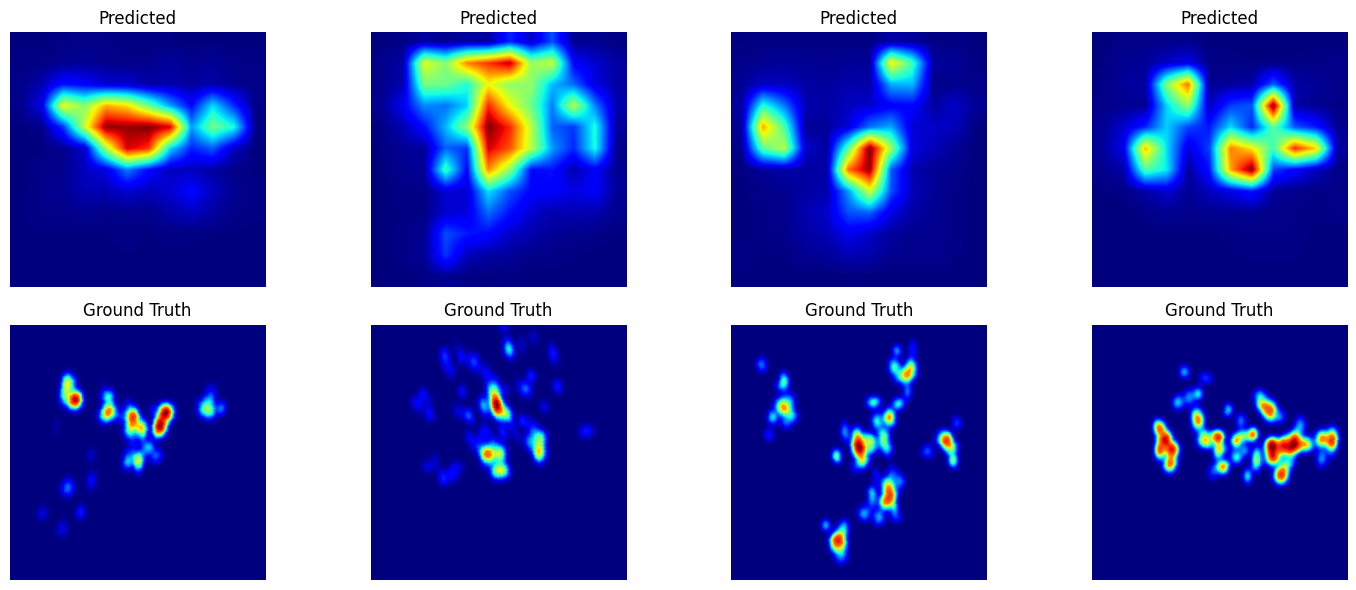

In [26]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    batch_data = next(iter(dataloader))
    images = batch_data["stimuli"].to(device)
    task_descs = batch_data["task_description"]
    pred_saliency = model(images, task_descs)

pred_saliency_np = pred_saliency.cpu().numpy()
fdm_np = batch_data["fdm"].cpu().numpy()

num_samples = pred_saliency_np.shape[0]
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
for i in range(num_samples):
    axes[0, i].imshow(pred_saliency_np[i, 0], cmap='jet')
    axes[0, i].set_title("Predicted")
    axes[0, i].axis('off')

    axes[1, i].imshow(fdm_np[i, 0], cmap='jet')
    axes[1, i].set_title("Ground Truth")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

Evaluate model performance

In [27]:
import torch

def correlation_coefficient(pred, gt):
    """
    Computes Pearson's Correlation Coefficient between two saliency maps.
    pred, gt: torch.Tensor of shape [H, W], assumed float in [0,1].
    Returns a scalar tensor (higher is better).
    """
    # Flatten to 1D
    pred_flat = pred.view(-1)
    gt_flat = gt.view(-1)

    pred_mean = pred_flat.mean()
    gt_mean = gt_flat.mean()

    numerator = ((pred_flat - pred_mean) * (gt_flat - gt_mean)).sum()
    denominator = torch.sqrt(((pred_flat - pred_mean)**2).sum() * ((gt_flat - gt_mean)**2).sum()) + 1e-12

    return numerator / denominator

def kl_divergence(pred, gt):
    """
    Computes KL Divergence between two saliency maps treated as probability distributions.
    pred, gt: torch.Tensor of shape [H, W], assumed float in [0,1].
    Returns a scalar tensor (lower is better).
    """
    eps = 1e-12
    # Normalize so each sums to 1
    pred_norm = pred / (pred.sum() + eps)
    gt_norm = gt / (gt.sum() + eps)

    return (gt_norm * torch.log((gt_norm + eps) / (pred_norm + eps))).sum()


In [28]:
def evaluate_saliency_model(model, dataloader, device):
    model.eval()
    cc_scores = []
    kld_scores = []

    with torch.no_grad():
        for batch_data in dataloader:
            images = batch_data["stimuli"].to(device)  # [B, 3, H, W]
            fdm = batch_data["fdm"].to(device)         # [B, 1, H, W]
            task_descs = batch_data["task_description"]

            # 1. Forward pass
            pred_saliency = model(images, task_descs)  # [B, 1, H, W]

            # 2. For each item in the batch
            for i in range(images.size(0)):
                pred_map = pred_saliency[i, 0]  # shape [H, W]
                gt_map = fdm[i, 0]             # shape [H, W]

                # 3. Compute metrics
                cc = correlation_coefficient(pred_map, gt_map)
                kld = kl_divergence(pred_map, gt_map)

                cc_scores.append(cc.item())
                kld_scores.append(kld.item())

    # 4. Compute averages
    avg_cc = sum(cc_scores) / len(cc_scores) if cc_scores else 0
    avg_kld = sum(kld_scores) / len(kld_scores) if kld_scores else 0

    print(f"Average CC: {avg_cc:.4f}")
    print(f"Average KLD: {avg_kld:.4f}")
    return avg_cc, avg_kld

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
avg_cc, avg_kld = evaluate_saliency_model(model, dataloader, device)


Average CC: 0.5743
Average KLD: 1.0711
